In [9]:
import librosa
import seaborn
import pandas
import numpy
import scipy.stats

import librosa.display
import matplotlib.pyplot as plt


## Distribution of MFCC values for spectrograms

The Mel-Frequency-Cepstral-Coefficients (MFCC) is computed as the DCT on log-scaled mel-spectrograms.
The output is a set of othogonal coefficients, which when summed together using the inverse DCT will give the original input
(since the coefficients are truncated to the first N, the mapping is only approximate).

Since the coefficients are part of a sum - the coefficients with larger values contribute more to the final output.
This makes it important to not truncate low/high values.
On the other hand, values near 0 contribute very little to the sum, and can be quantized/truncated/approximated with little loss.
This is the basis for many compression algorithms, such as JPEG for image, and MP3 for audio.

For a centered spectrogram (mean=0.0), the MFCC values will be approximately centered/symmetrical on 0.0.
However for non-centered spectrograms the distribution will be more skewed - because the sum of coefficients needs to be positive/negative overall.
This skew requires a larger range of values to represent.


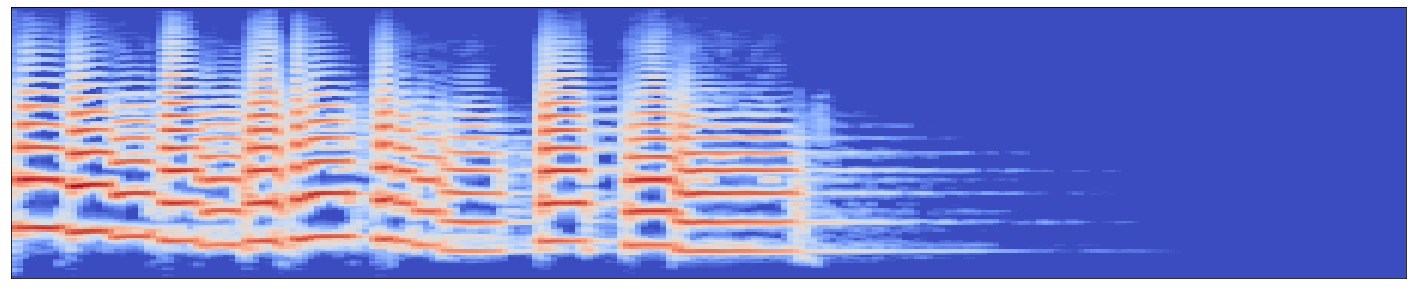

In [14]:
# Load some audio
y, sr = librosa.load(librosa.ex('trumpet'))

# Compute log-scaled mel-spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S = librosa.power_to_db(S) # log-scale

# Plot the original
fig, ax = plt.subplots(1, figsize=(25, 5))
librosa.display.specshow(S, ax=ax)

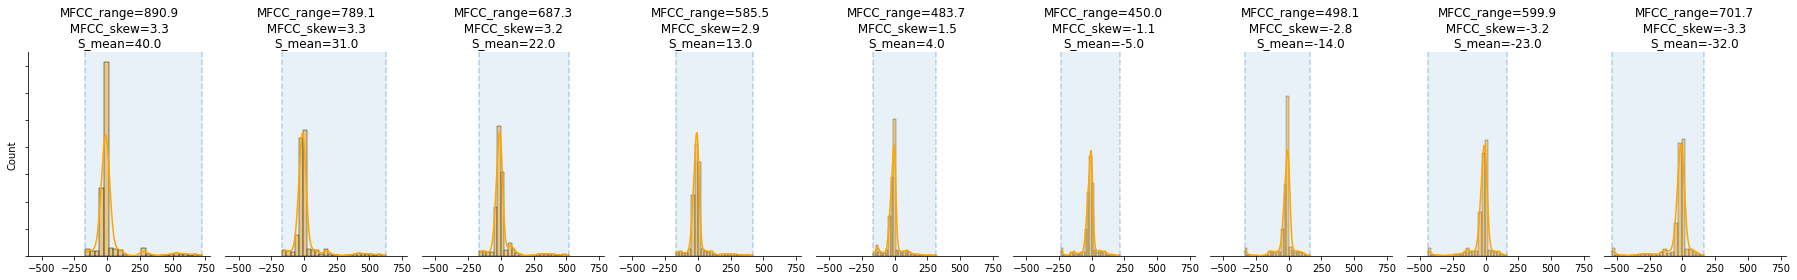

In [12]:
# Illustrate distribution of MFCC values for different spectrogram shifts/means

steps = 9
fig, axs = plt.subplots(ncols=steps, figsize=(25, 4), sharex=True, sharey=True)
for i, (ax, delta) in enumerate(zip(axs, numpy.arange(numpy.mean(S)-40, numpy.mean(S)+40, steps))):

    # Shift the log-mel spectrogram, then compute MFCC
    shifted = S - delta
    
    # Can scale, though it does not change shape of distribution
    #shifted /= numpy.std(shifted)
    
    m = librosa.feature.mfcc(S=shifted, n_mfcc=13)
    
    # Plot
    upper = numpy.max(m)
    lower = numpy.min(m)
    d = numpy.max(m)-numpy.min(m)
    skew = scipy.stats.skew(m.flatten())
    #print(d, delta, numpy.mean(shifted))

    #seaborn.kdeplot(ax=ax, data=m.flatten(), color='black')
    seaborn.histplot(ax=ax, data=m.flatten(), bins=25, color='orange', kde=True, kde_kws=dict())
    
    seaborn.despine(ax=ax)
    ax.axvline(upper, ls='--', alpha=0.3)
    ax.axvline(lower, ls='--', alpha=0.3)
    ax.axvspan(lower, upper, alpha=0.10)
    if i != 0:
        ax.set(yticklabels=[])
        ax.set(ylabel=None)
        ax.tick_params(right=False)
        ax.get_yaxis().set_visible(False)
        seaborn.despine(ax=ax, left=True)
    
    
    ax.set_title(f'MFCC_range={d:.1f}\n MFCC_skew={skew:.1f} \nS_mean={numpy.mean(shifted):.1f}')

fig.tight_layout()

#seaborn.histplot(m.flatten())

## MFCC normalization

It is only the first MFCC / DCT coefficient that changes during shifts of the spectrogram.


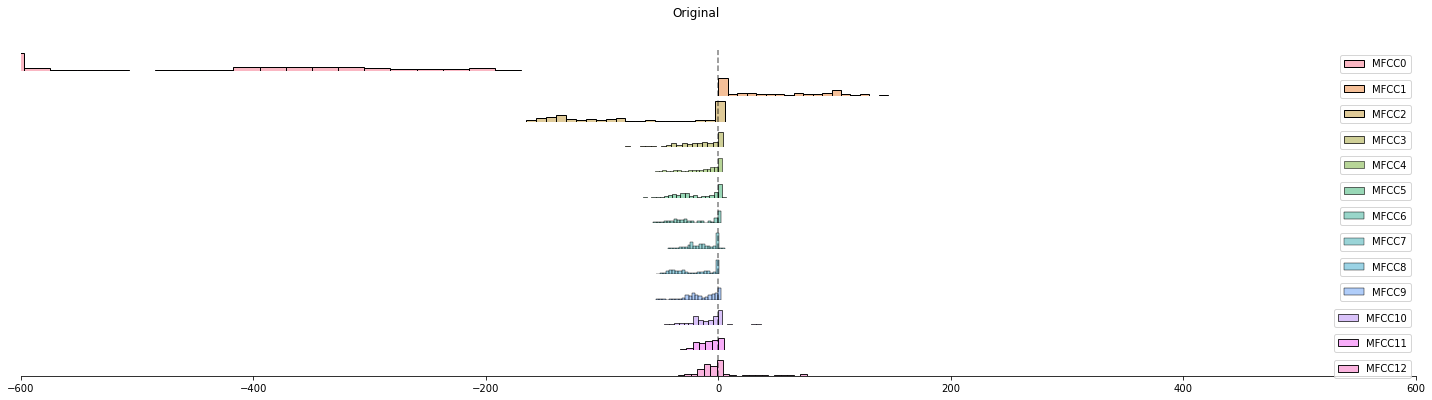

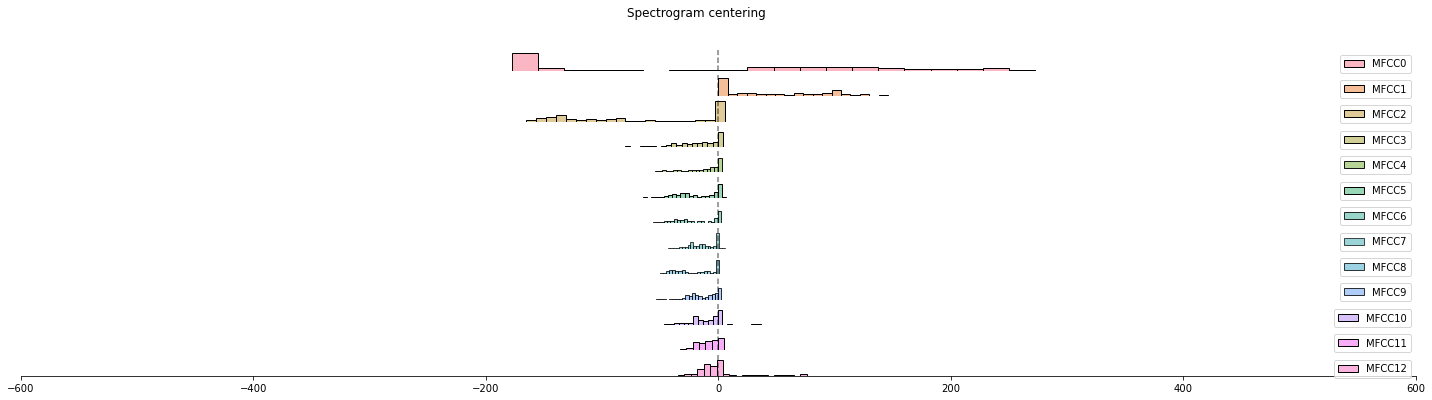

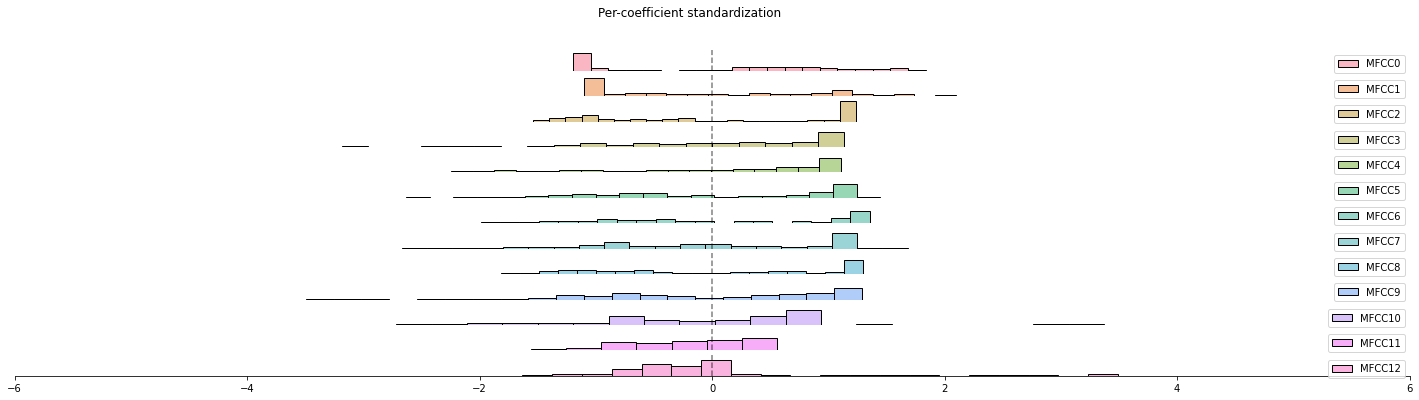

In [73]:

def plot_mfcc_distributions(m):

    n_coeffs = m.shape[0]
    fig, axs = plt.subplots(n_coeffs, figsize=(25,6), sharex=True, sharey=True)
    for coeff_no in range(n_coeffs):

        ax = axs[coeff_no]
        p = seaborn.color_palette("husl", m.shape[0])
        color = p[coeff_no]
        seaborn.histplot(m[coeff_no], color=color, label=f'MFCC{coeff_no}', alpha=0.5,ax=ax, bins=20)

        #ax.set(xticklabels=[])
        ax.set(yticklabels=[])
        ax.set(ylabel=None)
        ax.tick_params(right=False)
        ax.get_yaxis().set_visible(False)
        seaborn.despine(ax=ax, left=True)

        ax.axvline(0.0, ls='--', alpha=0.5, color='black')
        
        ax.legend(loc='upper right')

        if coeff_no != (n_coeffs-1):
            ax.get_xaxis().set_visible(False)
            seaborn.despine(ax=ax, bottom=True, left=True)
        
    return fig

def normalize(m):
    means = numpy.mean(m, axis=1, keepdims=True)
    #assert means.shape == 13, means.shape
    m -= means
    stds = numpy.std(m, axis=1, keepdims=True)
    m /= stds
    return m

n_mfcc = 13

m = librosa.feature.mfcc(S=S + 0, n_mfcc=n_mfcc)
fig = plot_mfcc_distributions(m)
fig.axes[0].set_xlim(-600, 600)
fig.suptitle("Original")

m = librosa.feature.mfcc(S=S - numpy.mean(S), n_mfcc=n_mfcc)
fig = plot_mfcc_distributions(m)
fig.axes[0].set_xlim(-600, 600)
fig.suptitle("Spectrogram centering")

m = librosa.feature.mfcc(S=S + 0, n_mfcc=n_mfcc)
m = normalize(m)
fig = plot_mfcc_distributions(m)
fig.axes[0].set_xlim(-6, 6)
fig.suptitle("Per-coefficient standardization")
    
None
